# LEFTIST 
Agnostic Local Explanation for Time Series Classification (LEFTIST) by Guilleme et al. (2019) [1] adapted LIME for time series classification and proposed to use prefixed (both the length and the position) shapelets as the interpretable components and provide the feature importance of each shapelet.

<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/LEFTIST_sun.png" alt="Visualization of Leftist" style="width: 800px;"/>

The code in TSInterpret is based on the authors <a href='https://www.dropbox.com/s/y1xq5bhpf0irg2h/code_LEFTIST.zip?dl=0'>implementation </a>. The image is reproduced from [1].

[1] Guillemé, Maël, et al. "Agnostic local explanation for time series classification." 2019 IEEE 31st International Conference on Tools with Artificial Intelligence (ICTAI). IEEE, 2019.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset
from tslearn.datasets import UCR_UEA_datasets
import sklearn

# Dataset

In [2]:
dataset='ElectricDevices'

# Load Data
Load Data and reshape the data to fit a 1D-Conv ResNet. Note that the input for a 1D-Conv Resnet hat the shape (batch, features, timesteps).

In [3]:
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,1,  train_x.shape[-2])
test_x = test_x.reshape(-1,1,  test_x.shape[-2])

In [4]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))    

# Model Training
Loads a pretrained 1D-Conv ResNet.

In [5]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))

<All keys matched successfully>

# Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

    1. Load the Interpretability Method
    2. Instaniate the Method with the desired Parameters
    3. Call the explain Method
    4. Plot the results

## 2. Initialization

LEFTIST works on all type of black-box classificators and can therefore be used with PyTorch (PYT), TensorFlow (TF), Sklearn (SK) and predict function, as long as the predict function returns a probability distribution. The Initialization takes the following arguments:

    
- `model_to_explain`: The model to be explaines. 
- `reference_set`: Reference Set of type (X_train, y_train).
- `mode`: Second dimension 'time' or 'feat'.
- `backend`: TF, PYT, SK or func.
- `transform_name`: Name of transformer.

        * `uniform`: Mean Transform 
        * `straight_line`: StraightlineTransform
        * `background`: RandBackgroundTransform


        
- `learning_process_name`: 'Lime' or 'Shap'.
- `nb_interpretable_feature`: number of desired features.




In [6]:
model.eval()
explained_instance = train_x[10]
nb_interpretable_feature = 10
explanation_size = 5
nb_neighbors = 1000
learning_process_name = 'Lime'
transform_name = 'straight_line'
model_to_explain=model

In [7]:
from TSInterpret.InterpretabilityModels.leftist.leftist import LEFTIST

In [8]:
leftist = LEFTIST(model_to_explain,(test_x,None),mode='feat', backend='PYT', \
learning_process_name='Lime',transform_name='straight_line')


## 3. Call the explain method.

Prepare the instance and the predicted label of the instance as parameters for the explain methods.
- `model_to_explain`: The model to be explaines. 
- `nb_neighbors`: Number if neighbors used in the calculatuions.
- `idx_label`: index of label to explain. If None, return an explanation for each label.
- `explanation_size`: Size of desired explanation.




In [9]:
explanations = leftist.explain(np.array(explained_instance),1000,explanation_size=explanation_size)

## 4. Visualize

Visualize the explanation by calling .plot().
Parameters are the original instance to be explained and the explanation. 


feat
NOT Time mode
-1
1
0


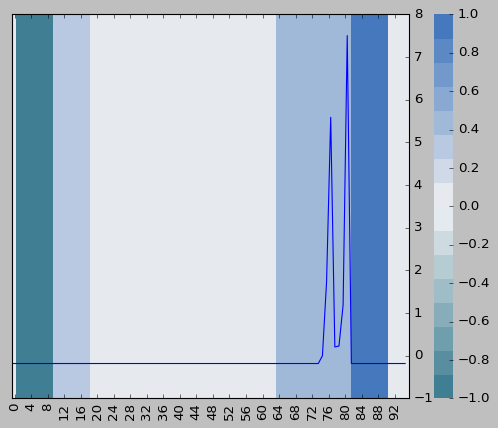

In [10]:
leftist.plot(np.array([explained_instance]),np.array([explanations[1]]))

Additional Examples, e.g. for the use with LSTM or TF can be found <a href='https://github.com/JHoelli/TSInterpret/blob/main/docs/Notebooks'>here</a>.